# Import required libraries

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data

In [17]:
data_filename = 'tactics/data/stats/metrics_valid_maia1600.csv'
df = pd.read_csv(data_filename)

# Do analysis

In [18]:
df.describe()

,total_positions,total_matches,num_suggestions,divergence,avg,correct_move
count,393.0,393.000000,393.000000,393.0,393.0,393.000000
mean,80.0,47.452926,47.452926,0.0,0.0,5.170483
std,0.0,2.763362,2.763362,0.0,0.0,3.029438
min,80.0,47.000000,47.000000,0.0,0.0,0.000000
25%,80.0,47.000000,47.000000,0.0,0.0,1.000000
50%,80.0,47.000000,47.000000,0.0,0.0,7.000000
75%,80.0,47.000000,47.000000,0.0,0.0,7.000000
max,80.0,80.000000,80.000000,0.0,0.0,11.000000


In [19]:
df

,text,total_positions,total_matches,num_suggestions,divergence,avg,correct_move
0,"f(A,B,C):-legal_move(B,C,A),attacks(B,E,A),beh...",80,47,47,0.0,0.0,7
1,"f(A,B,C):-legal_move(B,C,A),behind(B,D,E,A),be...",80,47,47,0.0,0.0,7
2,"f(A,B,C):-legal_move(B,C,A),behind(B,E,D,A),be...",80,47,47,0.0,0.0,7
3,"f(A,B,C):-legal_move(B,C,A),behind(B,E,D,A),be...",80,47,47,0.0,0.0,7
4,"f(A,B,C):-legal_move(B,C,A),attacks(B,D,A),beh...",80,47,47,0.0,0.0,1
...,...,...,...,...,...,...,...
388,"f(A,B,C):-legal_move(B,C,A),behind(B,D,E,A),be...",80,47,47,0.0,0.0,0
389,"f(A,B,C):-legal_move(B,C,A),attacks(B,D,A),beh...",80,47,47,0.0,0.0,7
390,"f(A,B,C):-legal_move(B,C,A),behind(B,D,E,A),di...",80,47,47,0.0,0.0,0
391,"f(A,B,C):-legal_move(B,C,A),attacks(B,C,A),beh...",80,47,47,0.0,0.0,7


Text(0, 0.5, 'Frequency')

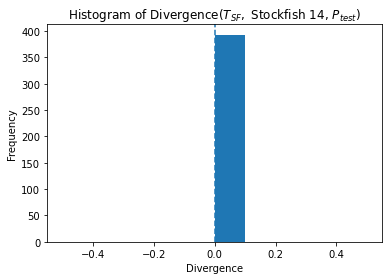

In [20]:
df['avg_divergence'] = df['divergence'] / df['total_matches']
plt.hist(df['avg_divergence'], bins=10)
plt.axvline(df.loc[(df['text'] == "f(A,B,C):-legal_move(B,C,A)")]['avg_divergence'].values, linestyle='dashed')
plt.title('Histogram of Divergence$(T_{SF},$ Stockfish 14, $P_{test})$')
plt.xlabel('Divergence')
plt.ylabel('Frequency')

In [72]:
df.loc[(df['text'] == "f(A,B,C):-legal_move(B,C,A)")]['avg_divergence'].values

array([93.075])

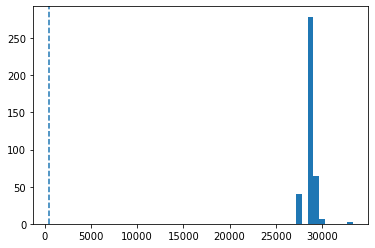

In [12]:
plt.hist(df['avg'], bins=10)
plt.axvline(df.loc[(df['text'] == "f(A,B,C):-legal_move(B,C,A)")]['avg_divergence'].values, linestyle='dashed')

Text(0, 0.5, 'Frequency')

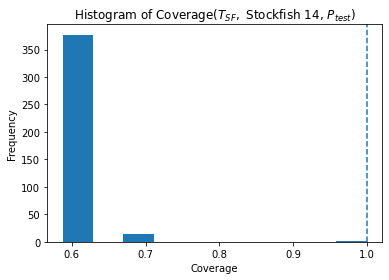

In [13]:
df['coverage'] = df['total_matches'] / df['total_positions']
plt.hist(df['coverage'], bins=10)
plt.axvline(df.loc[(df['text'] == "f(A,B,C):-legal_move(B,C,A)")]['coverage'].values, linestyle='dashed')
plt.title('Histogram of Coverage$(T_{SF},$ Stockfish 14, $P_{test})$')
plt.xlabel('Coverage')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

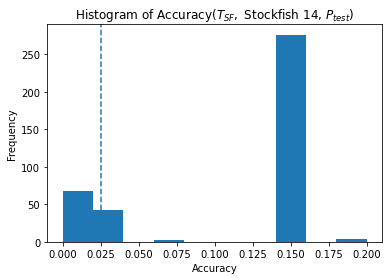

In [14]:
df['accuracy'] = df['correct_move'] / df['total_matches']
plt.hist(df['accuracy'], bins=10)
plt.axvline(df.loc[(df['text'] == "f(A,B,C):-legal_move(B,C,A)")]['accuracy'].values, linestyle='dashed')
plt.title('Histogram of Accuracy$(T_{SF},$ Stockfish 14, $P_{test})$')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')

In [15]:
final = df.sort_values(by = ['avg_divergence', 'total_matches', 'correct_move'], ascending = [True, False, False])[:39]

In [16]:
for tactic in sorted(final['text'].values.tolist()):
    print(tactic + '.')

f(A,B,C):-legal_move(B,C,A).
f(A,B,C):-legal_move(B,C,A),attacks(B,C,A).
f(A,B,C):-legal_move(B,C,A),attacks(B,C,A),attacks(B,D,A),different_pos(B,C),different_pos(B,D).
f(A,B,C):-legal_move(B,C,A),attacks(B,C,A),attacks(B,D,A),different_pos(B,D).
f(A,B,C):-legal_move(B,C,A),attacks(B,C,A),different_pos(B,C).
f(A,B,C):-legal_move(B,C,A),attacks(B,D,A),attacks(B,E,A),behind(B,D,E,A).
f(A,B,C):-legal_move(B,C,A),attacks(B,D,A),attacks(B,E,A),behind(B,D,E,A),different_pos(B,D).
f(A,B,C):-legal_move(B,C,A),attacks(B,D,A),attacks(B,E,A),different_pos(B,E),different_pos(B,D).
f(A,B,C):-legal_move(B,C,A),attacks(B,D,A),attacks(B,E,A),different_pos(C,D),different_pos(B,E).
f(A,B,C):-legal_move(B,C,A),attacks(B,D,A),attacks(B,E,A),different_pos(C,E),different_pos(B,D).
f(A,B,C):-legal_move(B,C,A),attacks(B,D,A),attacks(B,E,A),different_pos(C,E),different_pos(C,D).
f(A,B,C):-legal_move(B,C,A),attacks(B,D,A),behind(B,D,E,A),behind(B,E,D,A).
f(A,B,C):-legal_move(B,C,A),attacks(B,D,A),behind(B,D,E,

# Calculate Dataset Metrics

In [14]:
from collections import Counter

total_games = 0
valid_elo = 0
total_pos = 0
total_elo = 0
game_count = Counter()

pgn_path = 'tactics/data/lichess_db_standard_rated_2013-02.pgn'

In [15]:
import chess.pgn

with open(pgn_path) as pgn:
    while game := chess.pgn.read_game(pgn):
        total_games += 1
        white_elo = game.headers['WhiteElo']
        black_elo = game.headers['BlackElo']
        if '?' not in white_elo and '?' not in black_elo:
            total_elo += int(white_elo)
            total_elo += int(black_elo)
            valid_elo += 1
        game_count[game.headers['Event']] += 1

In [19]:
print('Total games', total_games)
avg_elo = total_elo / (2 * valid_elo)
print('Average ELO', avg_elo)

Total games 245293
Average ELO 1594.5634701202948


In [20]:
variance = 0

with open(pgn_path) as pgn:
    while game := chess.pgn.read_game(pgn):
        total_games += 1
        white_elo = game.headers['WhiteElo']
        black_elo = game.headers['BlackElo']
        if '?' not in white_elo and '?' not in black_elo:
            variance += (int(white_elo) - avg_elo) ** 2
            variance += (int(black_elo) - avg_elo) ** 2
        game_count[game.headers['Event']] += 1

In [21]:
import math

print('SD', math.sqrt(variance / valid_elo))

SD 297.6346612884856


# Test Evaluation

In [91]:
import chess
import chess.engine
from tactics.util import *

board = chess.Board('r1bqk1nr/ppp2ppp/3b4/3p4/8/2PNP3/PP3PPP/RNBQKB1R b KQkq - 2 7')
move1 = chess.Move.from_uci('g8h6')
move2 = chess.Move.from_uci('g8f6')
#engine_path = get_lc0_cmd(LC0, MAIA_1900) + ['--verbose-move-stats']
engine_path = STOCKFISH
mate_score = 2000

In [89]:
with chess.engine.SimpleEngine.popen_uci(engine_path) as engine:
    tmp_board = chess.Board(board.fen())
    tmp_board.push(move1)
    prev_eval = engine.analyse(board, limit=chess.engine.Limit(nodes=1), game=object())
    curr_eval = engine.analyse(tmp_board, limit=chess.engine.Limit(nodes=1), game=object())
    orig_turn = board.turn
    if 'pv' in prev_eval and 'pv' in curr_eval:
        prev_score = prev_eval['score'].pov(orig_turn)
        curr_score = curr_eval['score'].pov(orig_turn)
        move_score = curr_score.score(mate_score=mate_score) - prev_score.score(mate_score=mate_score)
        print(move_score)

-108


In [87]:
curr_score.score()

int

In [92]:
with chess.engine.SimpleEngine.popen_uci(engine_path) as engine:
    evals = get_evals(engine, board, [move1, move2])
evals

[(Cp(-1152), Move.from_uci('g8h6')), (Cp(-988), Move.from_uci('g8f6'))]